# **Proyecto del Curso: Clasificación de aptitud del suelo para la producción de Café en el departamento del Huila**
### Universidad Nacional de Colombia
### Programación SIG
### Integrantes:
* Cristian Santiago Acuña Ramírez
* Avdoni Sánchez Reinoso
    - Estudiantes de Maestría en Geomática

## 🎯 Objerivo: 

📜 El presente cuaderno de trabajo en JupyterLab tiene como objetivo principal identificar y clasificar las áreas con mayor potencial productivo para el cultivo de café, a partir de un análisis espacial y temático de aptitud del suelo. Para ello, se estructura un flujo de trabajo dividido en varias secciones que permiten una evaluación progresiva y fundamentada. Inicialmente, se selecciona el departamento con mayor relevancia en términos de producción cafetera a nivel nacional. Posteriormente, se realiza una clasificación preliminar de la aptitud del suelo en tres categorías (Alta, Media y Baja), integrando variables agronómicas clave. 

📊 A esta clasificación se le incorpora un análisis logístico que considera aspectos como el acceso a la red vial, la cercanía a estaciones climáticas y la disponibilidad de mano de obra, con el fin de ajustar la aptitud en función de las condiciones reales de acceso y operación. Finalmente, se excluyen aquellas áreas con restricciones legales o ambientales —como zonas de conservación, áreas protegidas o territorios con uso restringido—, con el propósito de garantizar que las zonas identificadas sean viables desde el punto de vista normativo. El resultado final se representa cartográficamente, consolidando una evaluación espacial de la aptitud del suelo para el cultivo de café en el departamento seleccionado.

### **1. Intalación de librerías.** 
En esta sección se integra el conjunto de librerías que se utilizarán para este proyecto.

In [44]:
# Librerías importadas
import geopandas as gpd  # Permite trabajar con datos geoespaciales como si fueran DataFrames de pandas
import pandas as pd  # Herramientas para análisis y manipulación de datos tabulares
import matplotlib.pyplot as plt  # Librería principal para crear gráficos y visualizaciones
import matplotlib.cm as cm  # Acceso a mapas de colores predefinidos para visualizaciones
import contextily as cx  # Agrega mapas base (tiles) a gráficos geoespaciales (como OpenStreetMap)
import numpy as np  # Operaciones matemáticas y manejo eficiente de arrays
import fiona  # Lectura y escritura de archivos geoespaciales (shapefiles, geopackage, etc.)
import os  # Permite interactuar con el sistema operativo (rutas, carpetas, etc.)
import contextily as ctx  # (Alias alternativo) para agregar mapas base en sistemas de coordenadas proyectadas
import shapely  # Manipulación y análisis de geometrías (puntos, líneas, polígonos)
import matplotlib.patches as mpatches  # Crear objetos gráficos como leyendas personalizadas o símbolos
from matplotlib.lines import Line2D # Permite crear y personalizar líneas para leyendas o anotaciones en gráficos de matplotlib
os.makedirs("Fig_project", exist_ok=True)  # Crea una carpeta para guardar figuras, si no existe
from pathlib import Path  # Manejo orientado a objetos de rutas de archivos
from matplotlib.colors import Normalize  # Normaliza valores para aplicarles mapas de colores
from shapely.geometry import Point  # Crear objetos de tipo punto (útil para estaciones, coordenadas, etc.)
from shapely.ops import unary_union  # Une múltiples geometrías en una sola (por ejemplo, límites municipales)
from shapely.ops import nearest_points  # Para encontrar el punto más cercano

##### import contextily as cx

# plt.rcParams['figure.figsize'] = (28, 8)

### **2. Carga de archivos de entrada (Preparación de los datos)**
#### **2.1 Rutas de entrada:** 
* En la siguiente sección se definen las rutas de acceso para los diferentes insumos que se van a utilizar en este proyecto:

In [2]:
# Rutas de los archivos

root_folder=r"/notebooks/datos/datos_proyecto" # Ruta de carpeta general

# Rutas a los archivos de entrada (Insumos)
shp_mun = root_folder + '/municipios/municipios_colombia.shp' # Shape de Municipios de Colombia
shp_frnt_agr = root_folder + '/frontera_agricola_abr2024/Frontera_Agricola_Abr2024.shp' # Shape de Fronteras Agrícolas
shp_runap = root_folder + '/runap/runap2Polygon.shp' # Shape Runap
CSV_inf_suel_hul = root_folder + '/Info_suelos_huila.csv' # Información adicional de suelos del huila
CSV_EVA = root_folder + '/EVAs_2019_2024.xlsx' # CSV de Evaluaciones Agropecuarias de 2019 - 2024
CSV_EST = root_folder + '/Catalogo_Estaciones_IDEAM.csv' # Estaciones Meteorológicas registradas por el IDEAM
gbd_vias = root_folder + '/red_vial.gdb'  # archivo tipo GeoPackage de Vías Nacionales
gbd_suel_huil = root_folder + '/SUELOS_HUILA_100K.gdb'  # archivo tipo GeoPackage de Características de los suelos del Huila
temp_path = root_folder+"/Clima/ACC2014_TmMd_AA_1981_2010.shp" # Archivo tipo shape con clasificación de temperatura media anual a nivel Nacional

print("Titulos de archivo de Vias Nacionales:\n", fiona.listlayers(gbd_vias), "\n")
print("Titulos de archivo de Suelos Huila:\n", fiona.listlayers(gbd_suel_huil))
print(fiona.listlayers(CSV_inf_suel_hul))

Titulos de archivo de Vias Nacionales:
 ['Via', 'Puente_L', 'Puente_P', 'Tunel', 'VFerre', 'LVia', 'SVial', 'T_1_DirtyAreas', 'T_1_PointErrors', 'T_1_LineErrors', 'T_1_PolyErrors'] 

Titulos de archivo de Suelos Huila:
 ['SUELOS_HUILA_100K_VF_20191001', 'T_1_DirtyAreas', 'T_1_PointErrors', 'T_1_LineErrors', 'T_1_PolyErrors']
['Info_suelos_huila']


#### **2.2 Lectura, corrección y proyección de datos:** 
* En la siguiente sección de código se leen los archivos, se proyectan y en el caso de las estaciones se convierte en tipo GeoDataFrame.

In [3]:
# Se cargan y se proyectan las entradas que son de tipo espacial.

# 2.2.1 Municipios
gdf_mun = gpd.read_file(shp_mun)
if gdf_mun.crs is None:
    gdf_mun.set_crs(epsg=4326, inplace=True)
gdf_mun = gdf_mun.to_crs(epsg=9377)

# 2.2.2 Frontera agrícola
gdf_frnt_agr = gpd.read_file(shp_frnt_agr)
if gdf_frnt_agr.crs is None:
    gdf_frnt_agr.set_crs(epsg=4326, inplace=True)
gdf_frnt_agr = gdf_frnt_agr.to_crs(epsg=9377)

# 2.2.3 Runap
gdf_runap = gpd.read_file(shp_runap, encoding='latin1')
if gdf_runap.crs is None:
    gdf_runap.set_crs(epsg=4326, inplace=True)
gdf_runap = gdf_runap.to_crs(epsg=9377)

# 2.2.4 Suelos Huila en escala 100K
gdf_suelos = gpd.read_file(gbd_suel_huil, layer="SUELOS_HUILA_100K_VF_20191001")
if gdf_suelos.crs is None:
    gdf_suelos.set_crs(epsg=4326, inplace=True)
gdf_suelos = gdf_suelos.to_crs(epsg=9377)

# 2.2.5 Cargar red vial (capa "Via" dentro del GeoPackage)
vias_col = gpd.read_file(gbd_vias, layer="Via")
if vias_col.crs is None:
    vias_col.set_crs(epsg=4326, inplace=True)
vias_col = vias_col.to_crs(epsg=9377)

# 2.2.6 Cargar archivo shape de temperatura
temp = gpd.read_file(temp_path)
if temp.crs is None:
    temp.set_crs(epsg=4326, inplace=True)
temp = temp.to_crs(epsg=9377)

# 2.2.7 Carga de archivo CSV de Información Adicional de suelos

df_inf_suel = pd.read_csv(CSV_inf_suel_hul, encoding='utf-8', sep = ";")

# 2.2.8 Carga de archivo CSV Evaluaciones Agropecuarias entre 2019 y 2014 (EVAs 2019-2014)

df_evas = pd.read_excel(CSV_EVA)
df_evas = df_evas.rename(columns={'Código Dane municipio': 'COD_MUNI'})
df_evas['COD_MUNI'] = df_evas['COD_MUNI'].astype(str).str.zfill(5)

# 2.2.9 Cargar archivo CSV de estaciones IDEAM y convertirlo en GeoDataFrame
df_est = pd.read_csv(CSV_EST)

    # - Nombre de la columna que guarda la coordenada en formato "(lat, lon)"
coord_col = "Ubicación"      

    # --> 1. Extraer latitud y longitud como dos columnas numéricas
coords = (
    df_est[coord_col]
      .str.strip("()")            # quitar paréntesis
      .str.split(",", expand=True)  # separar por coma
      .apply(pd.to_numeric)         # convertir a float
)
df_est["lat"] = coords[0]
df_est["lon"] = coords[1]

    # --> 2. Crear geometría punto a partir de lon, lat (EPSG:4326)
gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
)

    # --> 3. Reproyectar a EPSG:9377
gdf_est = gdf_est.to_crs(epsg=9377)

    # --> 4. Visualización

print("Estaciones IDEAM cargadas:", gdf_est.shape)
display(gdf_est.head())
print("Municipios:", gdf_mun.shape)
print("Red vial:", vias_col.shape)
print("EVAs:\n", df_evas.head())
print("Inf Suelos:\n", df_inf_suel.head())


Estaciones IDEAM cargadas: (8973, 14)


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5292824.016 1139928.729)


Municipios: (1122, 92)
Red vial: (112322, 9)
EVAs:
    Código Dane departamento Departamento COD_MUNI Municipio  \
0                         5    Antioquia    05001  Medellín   
1                         5    Antioquia    05001  Medellín   
2                         5    Antioquia    05001  Medellín   
3                         5    Antioquia    05001  Medellín   
4                         5    Antioquia    05001  Medellín   

       Desagregación cultivo   Cultivo Ciclo del cultivo Grupo cultivo  \
0  Aguacate demás variedades  Aguacate        Permanente      Frutales   
1  Aguacate demás variedades  Aguacate        Permanente      Frutales   
2  Aguacate demás variedades  Aguacate        Permanente      Frutales   
3  Aguacate demás variedades  Aguacate        Permanente      Frutales   
4  Aguacate demás variedades  Aguacate        Permanente      Frutales   

         Subgrupo   Año Periodo  Área sembrada (ha)  Área cosechada (ha)  \
0  Demás frutales  2019    2019               24

### **3. Ranking de departamentos importantes para Café** 📊
* Se analizarán la producción, rendimiento y área de siembra de Café, para identificar los departamentos más importantes para éste cultivo

#### **3.1 Filtro para Café**
* Creación de un nuevo DataFrame (cafe_eva) que contiene los datos para el cultivo de café para el año 2023.

In [4]:
# Filtro de datos para cultivo de café.
cafe_eva = (df_evas.query('Cultivo == "Café" & Año == 2023').copy())
print("Primeros 5 datos EVAs Café 2023:\n" ,cafe_eva.head())
print("\nTipos de datos EVAs Café 2023:\n" ,cafe_eva.dtypes)

Primeros 5 datos EVAs Café 2023:
      Código Dane departamento Departamento COD_MUNI   Municipio  \
60                          5    Antioquia    05001    Medellín   
428                         5    Antioquia    05004    Abriaquí   
598                         5    Antioquia    05021  Alejandría   
698                         5    Antioquia    05030       Amagá   
806                         5    Antioquia    05031      Amalfi   

    Desagregación cultivo Cultivo Ciclo del cultivo  \
60                   Café    Café        Permanente   
428                  Café    Café        Permanente   
598                  Café    Café        Permanente   
698                  Café    Café        Permanente   
806                  Café    Café        Permanente   

                         Grupo cultivo                           Subgrupo  \
60   Cultivos tropicales tradicionales  Cultivos tropicales tradicionales   
428  Cultivos tropicales tradicionales  Cultivos tropicales tradicionales   
5

#### **3.2 Agrupación de 3 parámetros a analizar**  
Seleccionamos tres distintos parámetros por departamento en un sólo DataFrame, para determinar cuáles son los más importantes:
 - Área sembrada (ha). -> suma
 - Producción (t). -> suma
 - Rendimiento (t/ha). -> promedio
   
**Nota:** Dado que ya se había filtrado por cultivo y por año se suman los primeros parámetros para sacar el total, para el rendimiento se hace un promedio ya que se necesita un valor general del departamento, no es un parámetro que se sume para este análisis.

In [23]:
print("Número de filas:", cafe_eva.shape[0])
cafe_dep = cafe_eva.groupby("Departamento").agg({
    "Área sembrada (ha)": "sum",
    "Producción (t)": "sum",
    "Rendimiento (t/ha)": "mean"
}).reset_index()

cafe_dep.head(32)
top_10_area = cafe_dep.sort_values(by='Área sembrada (ha)', ascending=False).head(10)
top_10_pro = cafe_dep.sort_values(by='Producción (t)', ascending=False).head(10)
top_10_rend = cafe_dep.sort_values(by='Rendimiento (t/ha)', ascending=False).head(10)
top_10_area.head()

Número de filas: 638


,Departamento,Área sembrada (ha),Producción (t),Rendimiento (t/ha)
12,Huila,147991.64,142524.31,1.099143
0,Antioquia,108760.73,95239.75,1.072581
23,Tolima,106837.22,75099.17,0.803421
7,Cauca,94873.60,83603.57,0.979412
4,Caldas,58200.39,50209.35,1.112400


#### **3.3 Comparación de Variables**  
* Elaboramos 3 gráficos de barras diferentes por variable, para analizar los departamentos más importantes para el café.
* El departamento seleccionado es huila, debido que aunque sea de mayor área y mayor producción, apenas es el quinto departamento con mayor rendimiento, lo que brinda una oportunidad de análisis para estudiar áreas que tengan mejores condiciones para aumentar dicho rendimiento.

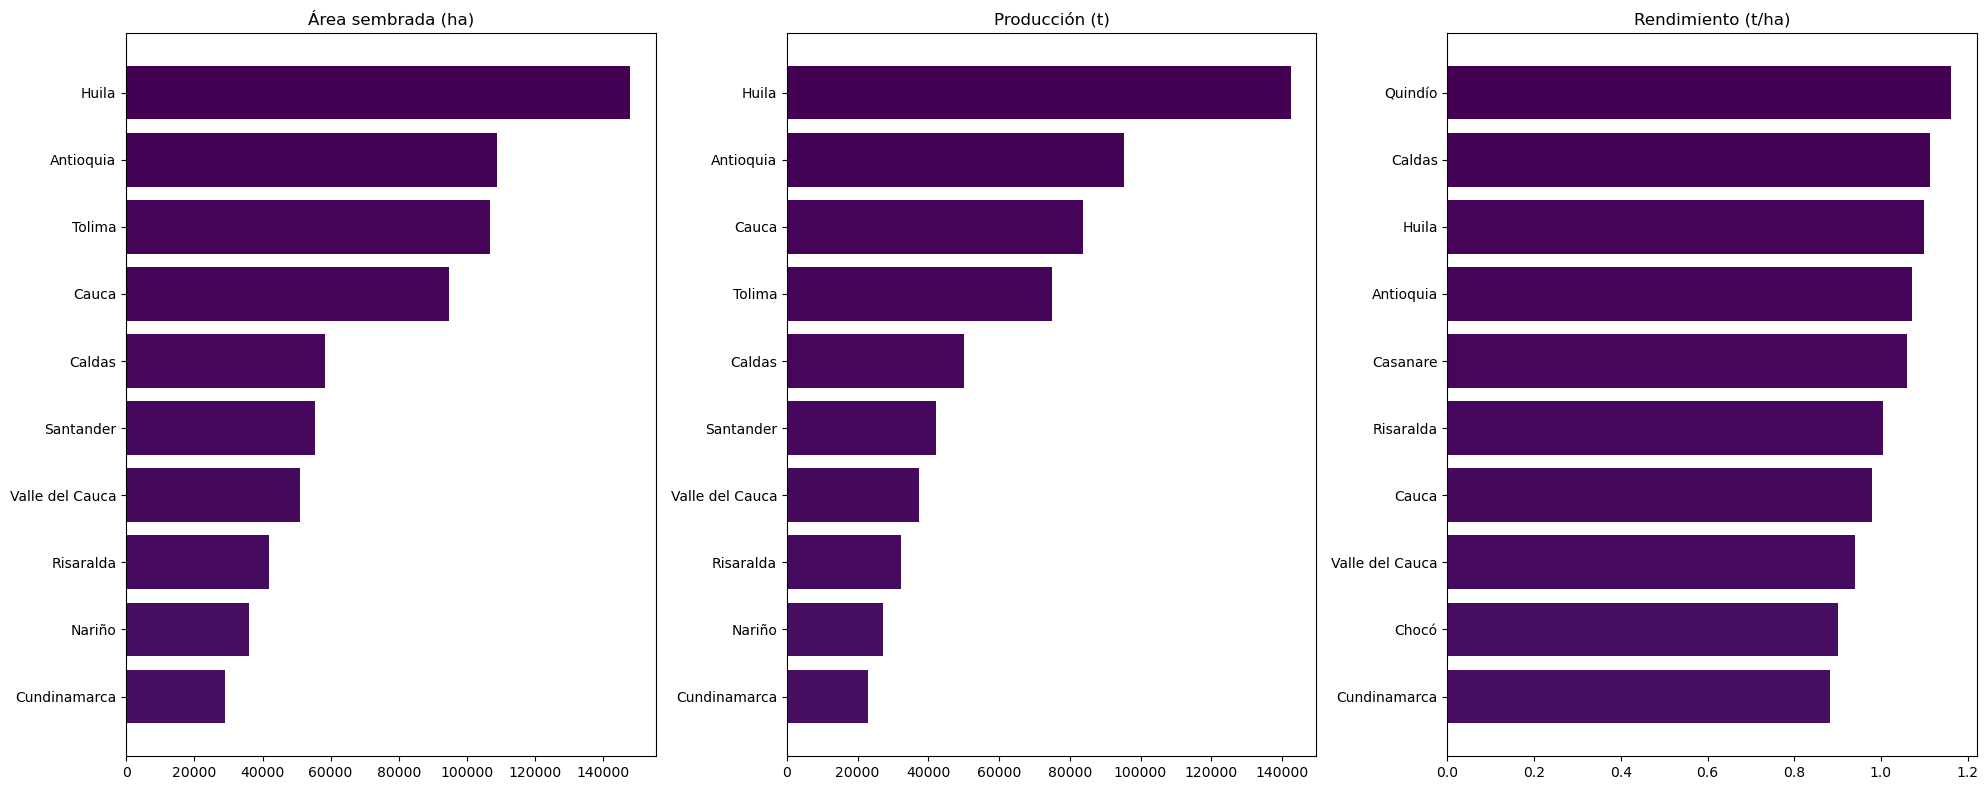

In [6]:
# Crear subgráficos
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=False)

# Colores opcionales
colors = plt.cm.viridis(range(10))

# Gráfico 1: Área sembrada
axes[0].barh(top_10_area["Departamento"], top_10_area["Área sembrada (ha)"], color=colors)
axes[0].set_title("Área sembrada (ha)")
axes[0].invert_yaxis()  # Para que el primer lugar quede arriba

# Gráfico 2: Producción
axes[1].barh(top_10_pro["Departamento"], top_10_pro["Producción (t)"], color=colors)
axes[1].set_title("Producción (t)")
axes[1].invert_yaxis()

# Gráfico 3: Rendimiento
axes[2].barh(top_10_rend["Departamento"], top_10_rend["Rendimiento (t/ha)"], color=colors)
axes[2].set_title("Rendimiento (t/ha)")
axes[2].invert_yaxis()

# Ajustar diseño
plt.tight_layout()
plt.show()

### **4. Clasificación por Variables Agronómicas** 
 * Vamos a integrar variables como Profundidad, Textura, Drenaje y Temperatura. Las cuáles son de carácter agronímico. Se compilan en un sólo GeoDataFrame para realizar la primera clasificación.
 * Inicialmente se realiza una visualización de los tipos de textura del estudio de suelos almacenados en `df_inf_suel`

In [8]:
df_inf_suel.head()

,UCS,Profundidad,Drenaje,Textura
0,MEA,Superficial,Bueno,A
1,MHA,Moderadamente profundo,Bueno,FA
2,MHB,Profundo,Bueno,FAr
3,MHC,Profundo,Bueno,FA
4,MKA,Moderadamente profundo,Bueno,FA


#### **4.1 Información de Textura de Suelos.**

* Ahora unimos la capa de suelos con información de textura utilizando como atributo clave = `UCS` visualizados anteriormente, con el `gdf_suelos`

In [9]:
suelo_huila = gdf_suelos.merge(df_inf_suel, on="UCS", how="left")
suelo_huila.head()

,UCS,UCSf,FASES,PAISAJE,CLIMA_AMBIENTAL,TIPO_RELIEVE,LITOLOGIA,CARACTERISTICAS,COMPONENTES_TAXONOMICOS,PERFILES,PORCENTAJE,AREA_ha,SHAPE_Length,SHAPE_Area,geometry,Profundidad,Drenaje,Textura
0,MQI,MQI,a,Montaña,Templado húmedo y muy húmedo,Vallecitos,Depósitos coluvio - aluviales heterométricos,"Moderadamente profundos, bien drenados, textur...","Asociación: Typic Udifluvents, Typic Eutrudept...",PL-9A; HL-21; HL-62,"50, 35, 15",538.340930,35285.637613,5.383397e+06,"MULTIPOLYGON (((4700273.602 1788150.861, 47003...",Moderadamente profundo,Bueno,F
1,MHC,MHC,"e, f, f2, g2",Montaña,Muy frío húmedo y muy húmedo,Filas y vigas,Mantos de ceniza volcánica sobre materiales íg...,"Son profundos y moderadamente profundos, bien ...","Asociación: Andic Humudepts, Typic Hapludands,...",PS-03; PC-113,"50, 40, 10",546.451314,12238.763923,5.476139e+06,"MULTIPOLYGON (((4608250.525 1787001.291, 46081...",Profundo,Bueno,FA
2,MQE,MQE,"c, d, e",Montaña,Templado húmedo y muy húmedo,Coladas de lodo y lahar,Mantos de ceniza volcánica e ignimbritas y dep...,"Son profundos y muy superficiales, bien drenad...","Asociación: Typic Hapludands, Typic Hapludalfs...","HL-42, PH-31; PG-250; HL-65","45, 35, 20",462.391605,10746.255328,4.626877e+06,"MULTIPOLYGON (((4674883.774 1783541.445, 46747...",Profundo,Bueno,FL
3,MQA,MQA,"e, e2, f, f2, g, g2",Montaña,Templado húmedo y muy húmedo,Filas y vigas,"Materiales ígneo - metamórficos (granitos, ton...","Son profundos, bien drenados, texturas moderad...","Asociación: Andic Dystrudepts, Andic Humudepts...",HL-48; HL-23,"50, 40, 10",1432.747009,33134.823691,1.433122e+07,"MULTIPOLYGON (((4695928.841 1787725.266, 46958...",Profundo,Bueno,FArL
4,MHC,MHC,"e, f, f2, g2",Montaña,Muy frío húmedo y muy húmedo,Filas y vigas,Mantos de ceniza volcánica sobre materiales íg...,"Son profundos y moderadamente profundos, bien ...","Asociación: Andic Humudepts, Typic Hapludands,...",PS-03; PC-113,"50, 40, 10",279.151390,7202.997160,2.797426e+06,"MULTIPOLYGON (((4608935.576 1787606.781, 46088...",Profundo,Bueno,FA


#### **4.2 Información de Temperatura**
* Generamos la intersección entre la información espacial de suelos con la temperatura.

In [11]:
huila_apt = gpd.overlay(temp, suelo_huila, how="intersection", keep_geom_type=False)

#### **4.3 Clasificación por variable.**  

* Realizamos la clasificación de la aptitud por variable Agronómica:

##### **4.3.1 Profundidad:**
* Inicialmente se exploran las categorías de Profundidad asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [14]:
print(huila_apt["Profundidad"].unique())

['Superficial' 'Moderadamente profundo' nan 'Muy superficial' 'Profundo']


In [15]:
def clasificar_profundidad(valor):
    if valor == "Profundo":
        return "A1"  # Aptitud Alta
    elif valor == "Moderadamente profundo":
        return "A2"  # Aptitud Media
    elif valor in ["Superficial", "Muy superficial"]:
        return "A3"  # Aptitud Baja
    else:
        return "N1" # No apto
huila_apt["Apt_profundidad"] = huila_apt["Profundidad"].apply(clasificar_profundidad)

##### **4.3.2 Textura**
* Inicialmente se exploran las categorías de Textura asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [16]:
print(huila_apt["Textura"].unique())

['FAr' 'FA' nan 'A' 'ArA' 'FL' 'Ar' 'F' 'FArL']


In [17]:
def clasificar_textura(valor):
    if valor in ["FAr", "FA", "FL", "F", "FArL"]:
        return "A1"  # Aptitud Alta
    elif valor in ["A", "ArA"]:
        return "A2"  # Aptitud Media
    elif valor == "Ar":
        return "A3"  # Aptitud Baja
    else:
        return "N1" # No apto
huila_apt["Apt_textura"] = huila_apt["Textura"].apply(clasificar_textura)

##### **4.3.3 Drenaje**
* Inicialmente se exploran las categorías de Drenaje asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [50]:
print(huila_apt["Drenaje"].unique())

['Bueno' nan 'Moderado' 'Pobre' 'Imperfecto' 'Excesivo' 'Muy pobre']


In [19]:
def clasificar_drenaje(valor):
    if valor == "Bueno":
        return "A1"  # Aptitud Alta
    elif valor in ["Moderado", "Excesivo"]:
        return "A2"  # Aptitud Media
    elif valor == "Imperfecto":
        return "A3"  # Aptitud Baja
    else:
        return "N1" # No apto
huila_apt["Apt_drenaje"] = huila_apt["Drenaje"].apply(clasificar_drenaje)

##### **4.3.4 Temperatura**
* Inicialmente se exploran las categorías de Temperatura asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [20]:
print(huila_apt["RANGO"].unique())

['< 8' '8 - 12' '12 - 16' '24 - 26' '> 28' '26 - 28' '22 - 24' '20 - 22'
 '16 - 20']


In [21]:
def clasificar_temperatura(valor):
    if valor == "20 - 22":
        return "A1"  # Aptitud Alta
    elif valor == "16 - 20":
        return "A2"  # Aptitud Media
    elif valor == "22 - 24":
        return "A3"  # Aptitud Baja
    else:
        return "N1" # No apto
huila_apt["Apt_temp"] = huila_apt["RANGO"].apply(clasificar_temperatura)

* Visualizamos el gdf resultante de toda la clasificación, `huila_apt`. 

In [22]:
print(huila_apt.head())

   OBJECTID  GRIDCODE   RANGO  Shape_Leng  Shape_Area  RULEID  UCS UCSf  \
0        57       1.0     < 8    3.912614    0.111046       1  MRA  MRA   
1        57       1.0     < 8    3.912614    0.111046       1  MLA  MLA   
2        57       1.0     < 8    3.912614    0.111046       1  MHA  MHA   
3        57       1.0     < 8    3.912614    0.111046       1   CA   CA   
4        62       2.0  8 - 12   10.201745    0.261900       2  MLA  MLA   

             FASES          PAISAJE  ...   SHAPE_Length    SHAPE_Area  \
0      f2, fp2, g2          Montaña  ...  132516.895283  1.065888e+08   
1         f, f2, g          Montaña  ...  151814.586969  2.349084e+08   
2             e, f          Montaña  ...   59373.736934  6.616768e+07   
3  Cuerpos de agua  Cuerpos de agua  ...     394.935167  1.008075e+04   
4         f, f2, g          Montaña  ...   30499.417054  1.240721e+07   

              Profundidad Drenaje Textura  \
0             Superficial   Bueno     FAr   
1             Superf

* Visualización gráfica del gdf de Huila

<Axes: >

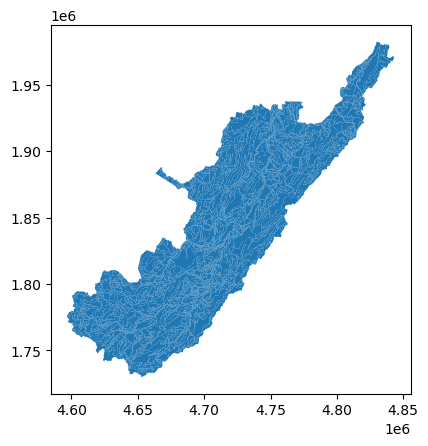

In [28]:
huila_apt.plot()

### 5. Claisificación por variables de Logistica   
Para mejorar la evaluación de suelos se integrarán 2 parámetros que son de importancia al momento de elegir áreas con mayor valor para producir Café:  

* Acceso a Vías.  
* Cercanía a estaciones Meteorológicas.  

#### **5.1 Acceso a vías**
* El objetivo es clasificar los polígonos según su cercanía a las vías principales.
##### **5.1.1 Calculo centroide**
* Primero cunatifificamosel centroide de cada polígono.

In [29]:
huila_apt["centroid"] = huila_apt.geometry.centroid
print(huila_apt.head())

   OBJECTID  GRIDCODE   RANGO  Shape_Leng  Shape_Area  RULEID  UCS UCSf  \
0        57       1.0     < 8    3.912614    0.111046       1  MRA  MRA   
1        57       1.0     < 8    3.912614    0.111046       1  MLA  MLA   
2        57       1.0     < 8    3.912614    0.111046       1  MHA  MHA   
3        57       1.0     < 8    3.912614    0.111046       1   CA   CA   
4        62       2.0  8 - 12   10.201745    0.261900       2  MLA  MLA   

             FASES          PAISAJE  ...    SHAPE_Area  \
0      f2, fp2, g2          Montaña  ...  1.065888e+08   
1         f, f2, g          Montaña  ...  2.349084e+08   
2             e, f          Montaña  ...  6.616768e+07   
3  Cuerpos de agua  Cuerpos de agua  ...  1.008075e+04   
4         f, f2, g          Montaña  ...  1.240721e+07   

              Profundidad Drenaje Textura  \
0             Superficial   Bueno     FAr   
1             Superficial   Bueno     FAr   
2  Moderadamente profundo   Bueno      FA   
3                   

##### **5.1.2 Filtrado de vías Nacionales para Departamento Huila**
* Primero se genera el polígono general del huila con un `union_all()`.
* Luego se realiza un filtrado espacial de las vías dentro de dicho polígono del Departamento del huila, se incluye visualización de las estaciones.

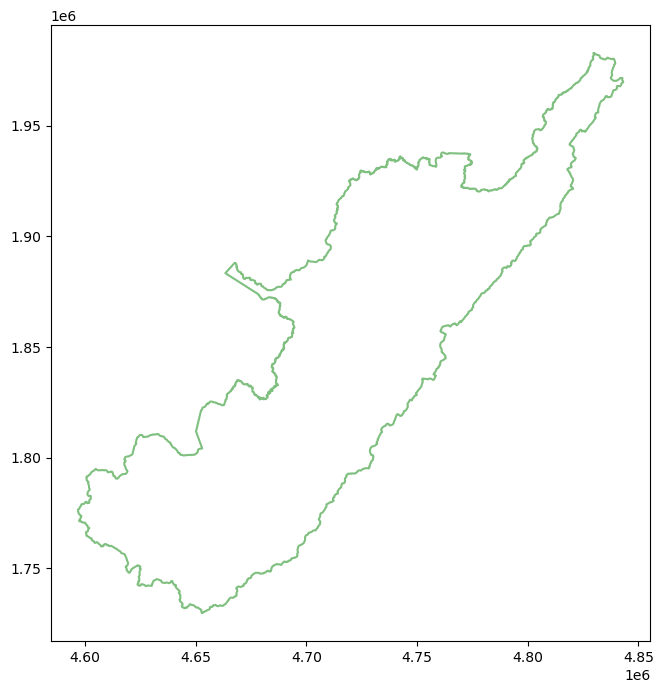

In [33]:
# Generando polígono de Huila, a partir de municipios
zona_es = huila_apt.union_all()
huila = gpd.GeoDataFrame(geometry=[zona_es], crs=9377)
fig, ax = plt.subplots(figsize=(8, 8))
huila.boundary.plot(ax=ax, color='green', alpha=0.5)
plt.show()

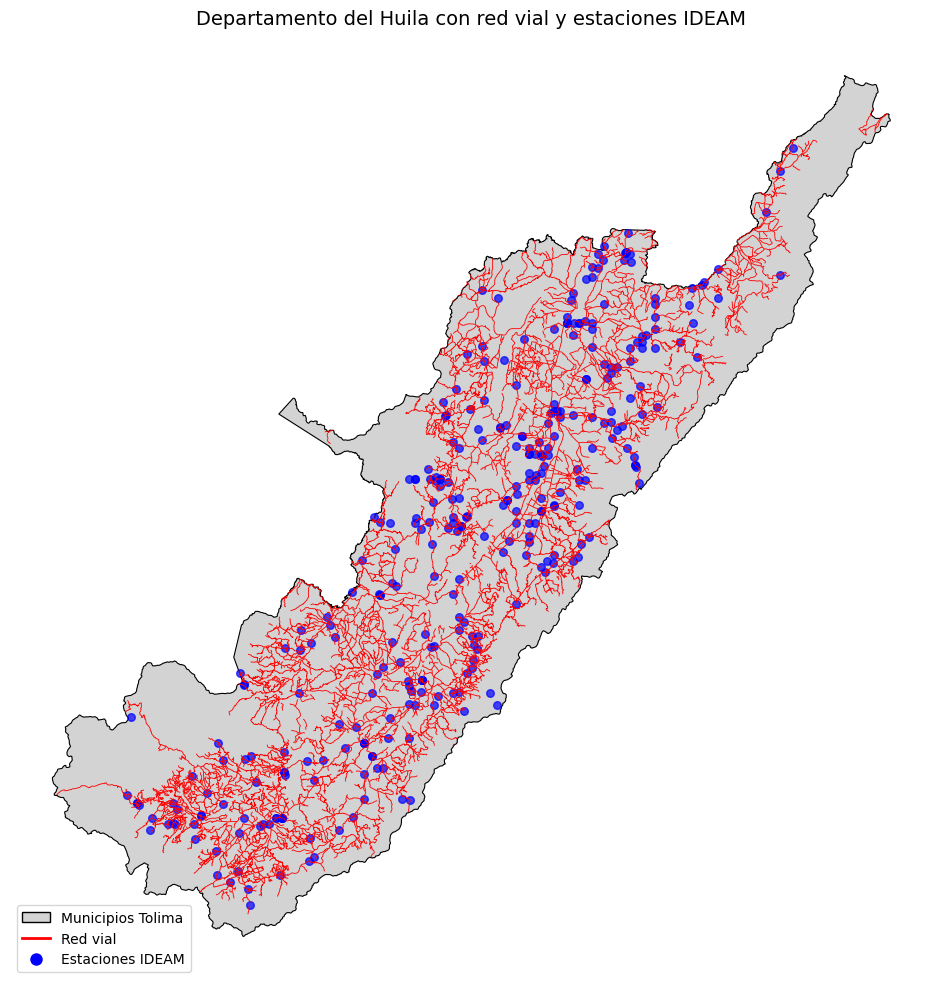

In [37]:
# Filtrar vías nacionales para el Huila
roads_huila_viz = gpd.clip(vias_col, huila)
gdf_est_huila = gdf_est[gdf_est.within(huila.geometry.union_all())]

# Crear Mapa
fig, ax = plt.subplots(figsize=(10, 10))
huila.plot(ax=ax, edgecolor="black", facecolor="lightgrey", linewidth=0.8)
roads_huila_viz.plot(ax=ax, color="red", linewidth=0.6)
gdf_est_huila.plot(ax=ax, color="blue", markersize=30, alpha=0.7)

# Título
ax.set_title("Departamento del Huila con red vial y estaciones IDEAM", fontsize=14)
ax.axis("off")

# Leyenda
legend_elements = [
    mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="Municipios Tolima"),
    Line2D([0], [0], color="red", lw=2, label="Red vial"),
    Line2D([0], [0], marker='o', color='w', label="Estaciones IDEAM",
           markerfacecolor='blue', markersize=10)
]
ax.legend(handles=legend_elements, loc="lower left")

plt.tight_layout()
plt.show()

##### **5.1.3 Cálculo de distancia a vía mas cercana**
* Calculamos la distancia más corta que existe entre una vía y el centroide de los polígonos generados.
* Se visualizan los cuartiles para generar los rangos y asignar las etiquetas de clasificación.

In [45]:
# Calcular la distancia mínima desde cada centroide a la geometría de las vías
huila_apt["dist_to_road_km"] = huila_apt["centroid"].apply(
    lambda pt: roads_huila_viz.distance(pt).min() / 1000  # Convertir a kilómetros
)

# Verifica el resultado
huila_apt[["dist_to_road_km"]].head()

,dist_to_road_km
0,5.435385
1,2.094036
2,0.950929
3,0.611992
4,10.754498


In [40]:
# Calcular los cuartiles y el valor máximo
cuartiles = huila_apt["dist_to_road_km"].quantile([0.25, 0.5, 0.75, 1.0])

# Mostrar los resultados
print("Cuartiles de dist_to_road_km:")
print(f"Q1 (25%): {cuartiles.loc[0.25]:.2f} km")
print(f"Q2 (50% - mediana): {cuartiles.loc[0.5]:.2f} km")
print(f"Q3 (75%): {cuartiles.loc[0.75]:.2f} km")
print(f"Q4 (100% - valor máximo): {cuartiles.loc[1.0]:.2f} km")


Cuartiles de dist_to_road_km:
Q1 (25%): 0.17 km
Q2 (50% - mediana): 0.46 km
Q3 (75%): 1.14 km
Q4 (100% - valor máximo): 17.26 km


##### **5.1.4 Clasificación por cercanía a Vía**
* A partir de los cuartiles se generan rangos para clasificar los polígonos

In [42]:
# Función para clasificar según distancia a vías
def clasificar_distancia(dist):
    if 0.0 <= dist < 0.17:
        return "A1"  # Aptitud Alta: muy cerca a vías
    elif 0.17 <= dist < 1.14:
        return "A2"  # Aptitud Media
    elif 1.14 <= dist <= 17.26:
        return "A3"  # Aptitud Baja: lejos de vías
    else:
        return "N1"  # No apto o fuera de rango

# Aplicar la función
huila_apt["Apt_road"] = huila_apt["dist_to_road_km"].apply(clasificar_distancia)
print(huila_apt.head())

   OBJECTID  GRIDCODE   RANGO  Shape_Leng  Shape_Area  RULEID  UCS UCSf  \
0        57       1.0     < 8    3.912614    0.111046       1  MRA  MRA   
1        57       1.0     < 8    3.912614    0.111046       1  MLA  MLA   
2        57       1.0     < 8    3.912614    0.111046       1  MHA  MHA   
3        57       1.0     < 8    3.912614    0.111046       1   CA   CA   
4        62       2.0  8 - 12   10.201745    0.261900       2  MLA  MLA   

             FASES          PAISAJE  ... Drenaje Textura  \
0      f2, fp2, g2          Montaña  ...   Bueno     FAr   
1         f, f2, g          Montaña  ...   Bueno     FAr   
2             e, f          Montaña  ...   Bueno      FA   
3  Cuerpos de agua  Cuerpos de agua  ...     NaN     NaN   
4         f, f2, g          Montaña  ...   Bueno     FAr   

                                            geometry Apt_profundidad  \
0  POLYGON ((4836716.649 1979934.966, 4837210.798...              A3   
1  POLYGON ((4835372.587 1973038.239, 483538

#### **5.2 Cercanía a Estaciones Meteorológicas**
* El objetivo es clasificar los polígonos según su cercanía a una estación meteorológica

##### **5.2.1 Cálcilo de distancia a estación mas cercana**
* Calculamos la distancia de la estación meteorológica más cercana y el centroide de los polígonos generados.
* Se visualizan los cuartiles para generar los rangos y asignar las etiquetas de clasificación.

In [47]:
# Función para calcular la distancia mínima entre un punto y una colección de geometrías
def distancia_minima(centroide, estaciones):
    nearest_geom = stations_union = gdf_est_huila.union_all()
    punto_mas_cercano = nearest_points(centroide, stations_union)[1]
    return centroide.distance(punto_mas_cercano) / 1000  # en kilómetros

# Calcular distancia para cada centroide
huila_apt["dist_to_station_km"] = huila_apt["centroid"].apply(
    lambda centroide: distancia_minima(centroide, gdf_est_huila)
)

In [48]:
# Calcular cuartiles y el valor máximo (100%)
q0 = huila_apt["dist_to_station_km"].quantile(0.00)  # Mínimo
q1 = huila_apt["dist_to_station_km"].quantile(0.25)
q2 = huila_apt["dist_to_station_km"].quantile(0.50)
q3 = huila_apt["dist_to_station_km"].quantile(0.75)
q4 = huila_apt["dist_to_station_km"].quantile(1.00)  # Máximo (100%)

# Mostrar los resultados
print("Q0 (min):", q0)
print("Q1 (25%):", q1)
print("Q2 (50%):", q2)
print("Q3 (75%):", q3)
print("Q4 (100%):", q4)

Q0 (min): 0.10792698302538224
Q1 (25%): 2.131324436759546
Q2 (50%): 3.6128899862948045
Q3 (75%): 6.037798784482914
Q4 (100%): 41.397157890074


##### **5.2.2 Clasificación según cercanía a una Estación Meteorológica**
* Se clasifican los polígonos con base a la distancia que hay a la estación meteorológica más cercana

In [49]:
# Función de clasificación de aptitud según distancia a estación
def clasificar_distancia_estacion(distancia):
    if distancia <= 2:
        return "A1"  # Aptitud Alta
    elif distancia <= 6:
        return "A2"  # Aptitud Media
    elif distancia <= 15:
        return "A3"  # Aptitud Baja
    else:
        return "N1"  # No apto

# Aplicar la función al GeoDataFrame
huila_apt["Apt_estacion"] = huila_apt["dist_to_station_km"].apply(clasificar_distancia_estacion)
print(huila_apt.head())

   OBJECTID  GRIDCODE   RANGO  Shape_Leng  Shape_Area  RULEID  UCS UCSf  \
0        57       1.0     < 8    3.912614    0.111046       1  MRA  MRA   
1        57       1.0     < 8    3.912614    0.111046       1  MLA  MLA   
2        57       1.0     < 8    3.912614    0.111046       1  MHA  MHA   
3        57       1.0     < 8    3.912614    0.111046       1   CA   CA   
4        62       2.0  8 - 12   10.201745    0.261900       2  MLA  MLA   

             FASES          PAISAJE  ...  \
0      f2, fp2, g2          Montaña  ...   
1         f, f2, g          Montaña  ...   
2             e, f          Montaña  ...   
3  Cuerpos de agua  Cuerpos de agua  ...   
4         f, f2, g          Montaña  ...   

                                            geometry Apt_profundidad  \
0  POLYGON ((4836716.649 1979934.966, 4837210.798...              A3   
1  POLYGON ((4835372.587 1973038.239, 4835387.806...              A3   
2  MULTIPOLYGON (((4840138.652 1966847.157, 48402...              A2